## Imports

In [1]:
import sys
sys.path.append('../')
import gc
import pandas as pd
import numpy as np

from src.fetch_data import DataLoader
from src.exploration import Analysis
from src.cleaning import CleanDataFrame
from src.visualization import Plotters


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


cleaner = CleanDataFrame()
analyzer = Analysis()
plotters = Plotters(w=6, h=4)

# pd.options.plotting.backend = 'matplotlib'
plt.rcParams.update({'font.size': 24})
# plt.rcParams.update({'xtick.labelsize': 'large'})
# plt.rcParams.update({'ytick.labelsize': 'large'})
plt.rcParams.update({'legend.fontsize': 24})
%matplotlib inline
# plt.rcParams.keys()



## Fetch the dataframes

In [2]:
# Then load the raw sales data
data_path = 'data/merged/train.csv'
version = 'merged_v1'
repo = '../'

train_df = DataLoader.dvc_get_data(data_path, version, repo)

# Finally load the test data
data_path = 'data/merged/test.csv'
version = 'merged_v1'
repo = '../'

test_df = DataLoader.dvc_get_data(data_path, version, repo)

DataLoaderLogger - INFO - DVC: CSV file read with path: data/merged/train.csv | version: merged_v1 | from: ../
DataLoaderLogger - INFO - DVC: CSV file read with path: data/merged/test.csv | version: merged_v1 | from: ../


# Question Guided EDA


## 1. Are the promotions distributed similarly in both training and test sets?

YES


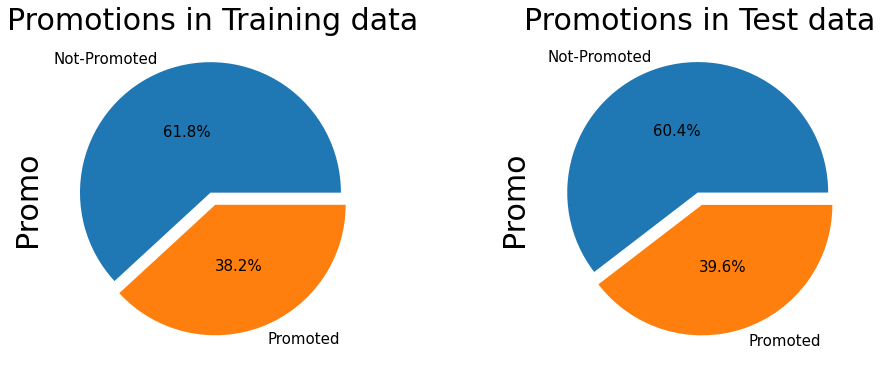

In [3]:

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

lable_font_size = 30
textprops = {"fontsize":15}
labels = {'Not-Promoted': 0, 'Promoted': 1}
train_promo_count = train_df["Promo"].value_counts().to_frame()

# plt.title("Ratio of overall promotions",
#           fontsize=20, loc='left')
axs[0].pie(data=train_promo_count,
           x='Promo',
           autopct="%.1f%%",
           explode=[0.05]*2,
           labels=labels,
           pctdistance=0.5,
           textprops=textprops,
           )
axs[0].set_label(labels)
axs[0].set_ylabel('Promo', fontsize=lable_font_size)
# axs[0].set_label(labels, fontsize=lable_font_size)
axs[0].set_title('Promotions in Training data', fontsize=lable_font_size)

test_promo_count = test_df["Promo"].value_counts().to_frame()
axs[1].pie(data=test_promo_count,
           x='Promo',
           autopct="%.1f%%",
           explode=[0.05]*2,
           labels=labels,
           pctdistance=0.5,
           textprops=textprops,
           )

axs[1].set_ylabel('Promo', fontsize=lable_font_size)
axs[1].set_title('Promotions in Test data', fontsize=lable_font_size)



print("YES")


## 2. What does sales behavior look like before, during and after holidays?

To answer this, I will first look at how the holidays are distributed.

*StateHoliday*

- 0 -> None
- a -> Public Holiday
- b -> Easter
- c -> Christmass

In [4]:
school_holidays = train_df.query("SchoolHoliday==1")
school_holidays.groupby("DayOfWeek")[['SchoolHoliday']].mean()

,SchoolHoliday
DayOfWeek,
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0


In [5]:
grouped_by_date = train_df.groupby('Date')[['Customers', 'Sales', 'SalesPerCustomer']]
grouped_by_date = grouped_by_date.sum()
grouped_by_date

,Customers,Sales,SalesPerCustomer
Date,,,
2013-01-01,19491,97235,84.826752
2013-01-02,834075,6949829,9708.032399
2013-01-03,761040,6347820,9709.819394
2013-01-04,782137,6638954,9818.033076
2013-01-05,687472,5951593,9971.772244
...,...,...,...
2015-07-27,970462,10707292,12772.675924
2015-07-28,876092,9115073,12137.994224
2015-07-29,828524,8499962,11976.079334


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [7]:
holiday_dates = train_df[(train_df[["StateHoliday"]].isin(['a', 'b', 'c']) | train_df[['SchoolHoliday']]!=0)]['Date'].unique()
holiday_dates.shape


(1,)

In [8]:
holiday_dates = train_df[(~train_df["StateHoliday"].isin(['0']) | train_df['SchoolHoliday']!=0)]['Date'].unique()
holiday_dates.shape


(487,)

## 3. Are there any seasonal (Christmas, Easter etc) purchase behaviours?

In [9]:
christmas = train_df.query("StateHoliday=='c'")
christmas_dates = christmas.groupby('Date')['Date'].unique().values
print(f"There are {christmas_dates.shape[0]} christmas_dates")
christmas_dates = [a[0] for a in christmas_dates.tolist()]

easter = train_df.query("StateHoliday=='b'")
easter_dates = easter.groupby('Date')['Date'].unique().values
print(f"There are {easter_dates.shape[0]} easter_dates")
easter_dates = [a[0] for a in easter_dates.tolist()]

public_holiday = train_df.query("StateHoliday=='a'")
public_holiday_dates = public_holiday.groupby('Date')['Date'].unique().values
print(f"There are {public_holiday_dates.shape[0]} public_holiday_dates")
public_holiday_dates = [a[0] for a in public_holiday_dates.tolist()]

# holiday_dates.shape
# holiday_dates = pd.to_datetime(holiday_dates)


There are 4 christmas_dates
There are 6 easter_dates
There are 27 public_holiday_dates


In [10]:
grouped_by_date = train_df.groupby('Date')['Sales'].sum().to_frame()
ax = px.line(grouped_by_date)
colors = ['black', 'green', 'red']
holiday_names = ['Public', 'Christmas', 'Easter']
for idx, holiday_type in enumerate([public_holiday_dates, christmas_dates, easter_dates]):
    for holiday in holiday_type:
        ax.add_vline(x=holiday, line={'color': colors[idx]})

ax.show()


## 4. Correlation between sales and number of customers

Text(0.5, 1.0, 'Correlation map of selected sales and store features')

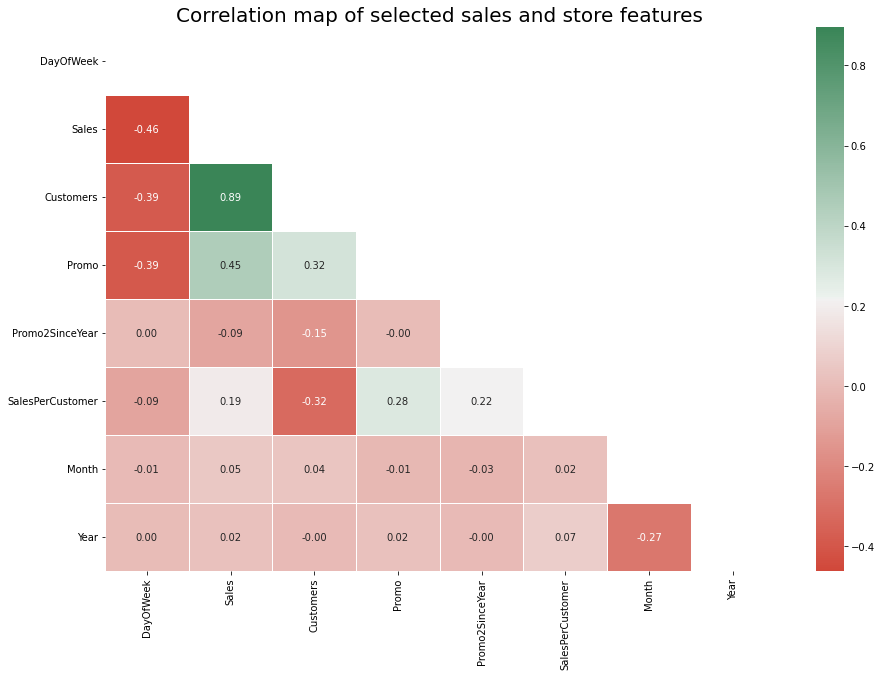

In [12]:
df_correlation = train_df[['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
                           'Promo2SinceYear', 'SalesPerCustomer', 'Month', 'Year',
                           'StateHoliday', 'Assortment', 'StoreType',
                           'PromoInterval']]

df_correlation=df_correlation.drop('Open', axis = 1)
upper_triangle = np.zeros_like(df_correlation.corr(), dtype=bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_correlation.corr(),
            ax=ax,
            annot=True,
            mask=upper_triangle,
            fmt='.2f',
            linewidths=0.5,
            cmap=sns.diverging_palette(15, 500, as_cmap=True))
ax.set_title("Correlation map of selected sales and store features", fontsize=20)


## 5. How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?


In [48]:
grouped_by_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby('Promo')['Sales'].describe().transpose()
grouped_by_promo

Promo,0,1
count,467463.000000,376875.000000
mean,5929.826183,8228.739731
std,2629.269229,3175.253594
min,46.000000,133.000000
25%,4242.000000,6070.000000
50%,5459.000000,7650.000000
75%,7004.000000,9686.000000
max,41551.000000,38722.000000


Text(0.5, 1.0, 'Average Sales vs Promo')

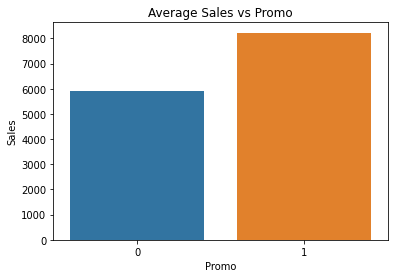

In [53]:
# sum_sale_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby('Promo')['Sales'].sum().to_frame()
# ax = sns.barplot(data=sum_sale_promo, x=sum_sale_promo.index, y='Sales')
# ax.set_title("Total Sales and Promo")

mean_sale_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby('Promo')['Sales'].mean().to_frame()
ax = sns.barplot(data=mean_sale_promo, x=mean_sale_promo.index, y='Sales')
ax.set_title("Average Sales vs Promo")

Text(0.5, 1.0, 'Total Customers vs Promo')

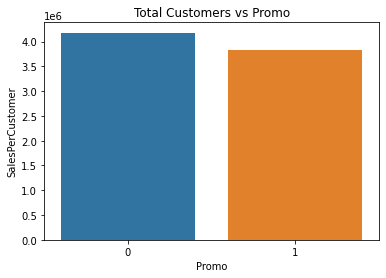

In [52]:
total_customers_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby('Promo')['SalesPerCustomer'].sum().to_frame()
ax = sns.barplot(data=total_customers_promo, x=total_customers_promo.index, y='SalesPerCustomer')
ax.set_title("Total Customers vs Promo")

The promos do increase the sales, but the number of customers is actually decreases. 

But it doesn't mean it's a bad thing since customers are actually spending more during tha Promos.

Since there are fewer customers during the Promos, I conclude that some are not too happy about the promos and choose to stay away.

## 6. Could the promos be deployed in more effective ways? Which stores should promos be deployed in?


In [55]:
grouped_by_store = train_df.groupby('Store')[['Sales', 'Customers']].sum()
grouped_by_store.head()

,Sales,Customers
Store,,
1,3716854,440523
2,3883858,457855
3,5408261,584310
4,7556507,1036254
5,3642818,418588


Let's look at the distribution of Sales and Customers per store

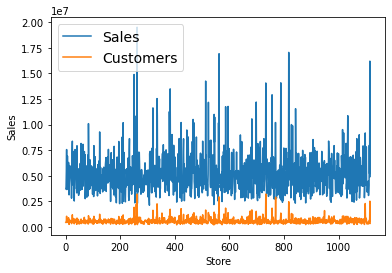

In [75]:
sns.lineplot(data=grouped_by_store, x=grouped_by_store.index, y='Sales')
sns.lineplot(data=grouped_by_store, x=grouped_by_store.index, y='Customers')
plt.legend(['Sales', 'Customers'], fontsize=14)

## 8. Which stores are opened on all weekdays? How does that affect their sales on weekends? 


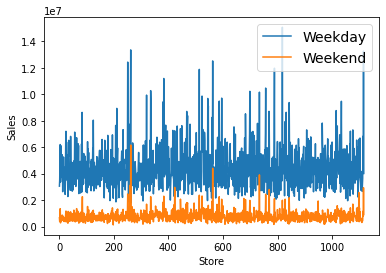

In [123]:
# stores_open_on_weekdays = train_df.query("DayOfWeek!=7 & DayOfWeek!=6 & Open==1")['Store'].unique()
stores_open_on_weekdays = train_df.query("Open==1")['Store'].unique()
sales_stores_open_on_weekdays = train_df[(train_df["Store"].isin(stores_open_on_weekdays) &train_df['Open']==1 & ~train_df['DayOfWeek'].isin([6,7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekdays)
sales_stores_open_on_weekdays = train_df[(train_df["Store"].isin(stores_open_on_weekdays) &train_df['Open']==1 & train_df['DayOfWeek'].isin([6,7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekdays)
plt.legend(['Weekday', 'Weekend'], fontsize=14, loc='upper right')

I have plotted the weekday and weekend sales for store that were open in both type of days. Sales on Weekends are significanly lower than on weekdays.

But, I can't be certain that this has to do with the fact that they were also open during the week days. 

Most stores are closed on weekends, so sales are generally down on weekends.

In [93]:
train_df['DayOfWeek']>5

0          False
1          False
2          False
3          False
4          False
           ...  
1017204     True
1017205    False
1017206    False
1017207    False
1017208    False
Name: DayOfWeek, Length: 1017209, dtype: bool